# Hooman HALABICHIAN
## MSc AI

# Import the Dataset

This command installs the "text-flappy-bird-gym" package from a GitLab repository (Stergios Christodoulidis). 

In [7]:
%pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-ji3zl5j_
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-ji3zl5j_
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done


# Import the packages

In [13]:
import gymnasium as gym
import text_flappy_bird_gym
import numpy as np
import matplotlib
from pylab import plt, mpl
from collections import defaultdict
import time
import pandas as pd
import os
import sys
import pickle
import logging

# Visualizations

In [14]:
# visusalization compare agent scores
def compare_agent_scores(scores_dict):
    fig, ax = plt.subplots(figsize=(12, 7))

    for agent_name, scores in scores_dict.items():
        x = range(1, len(scores) + 1)
        y = np.polyval(np.polyfit(x, scores, deg=3), x)
        ax.plot(scores, label=f'{agent_name} Scores')
        ax.plot(x, y, '--', label=f'{agent_name} Regression Scores')

    ax.set_xlabel('Episodes')
    ax.set_ylabel('Sum of Rewards during Episode')
    ax.set_title('Comparison of RL Agents')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(frameon=False, fontsize='large')
    plt.show()

# visusalization moving average
def moving_average(data, size):
    return [sum(data[i:i+size])/size for i in range(len(data)-size+1)]

# visusalization moving average rewards
def plot_moving_average_rewards(agent_scores, size=1000):
    for name in agent_scores.keys():
        rewards_list = agent_scores[name]
        moving_means = moving_average(rewards_list, size=size)
        plt.plot([size * episode for episode in range(0, len(moving_means))], moving_means, label=name, linewidth=2)
    plt.xlabel("Episodes")
    plt.ylabel("Sum of\n rewards\n during\n episode", rotation=0, labelpad=40)
    plt.legend()
    plt.show()

# visusalization average rewards
def plot_average_rewards(agent_scores, window_size=100):
    for agent_name in agent_scores.keys():
        rewards = agent_scores[agent_name]
        avg_rewards = [np.mean(rewards[i:i + window_size]) for i in range(len(rewards) - window_size + 1)]
        plt.plot([window_size * episode for episode in range(len(avg_rewards))], avg_rewards, label=agent_name, linewidth=2)
    
    plt.xlabel("Episodes")
    plt.ylabel("Average\n rewards\n during\n episode", rotation=0, labelpad=40)
    plt.legend()
    plt.show()

# visusalization min max rewards
def plot_min_max_rewards(agent_scores, window_size=100):
    for agent_name in agent_scores.keys():
        rewards = agent_scores[agent_name]
        min_rewards = [np.min(rewards[i:i + window_size]) for i in range(len(rewards) - window_size + 1)]
        max_rewards = [np.max(rewards[i:i + window_size]) for i in range(len(rewards) - window_size + 1)]

        plt.fill_between([window_size * episode for episode in range(len(min_rewards))], min_rewards, max_rewards, alpha=0.5, label=f"{agent_name} Min-Max")
    
    plt.xlabel("Episodes")
    plt.ylabel("Min-Max\n rewards\n during\n episode", rotation=0, labelpad=40)
    plt.legend()
    plt.show()

# visusalization sd rewards
def plot_standard_deviation_rewards(agent_scores, window_size=100):
    for agent_name in agent_scores.keys():
        rewards = agent_scores[agent_name]
        std_rewards = [np.std(rewards[i:i + window_size]) for i in range(len(rewards) - window_size + 1)]
        plt.plot([window_size * episode for episode in range(len(std_rewards))], std_rewards, label=agent_name, linewidth=2)
    
    plt.xlabel("Episodes")
    plt.ylabel("Standard\n deviation\n rewards\n during\n episode", rotation=0, labelpad=40)
    plt.legend()
    plt.show()

# visusalization success rate
def plot_success_rate(agent_scores, window_size=100):
    success_rates = {}
    for agent_name in agent_scores.keys():
        rewards = agent_scores[agent_name]
        success_counts = [np.count_nonzero(np.array(rewards[i:i + window_size]) >= 1) for i in range(len(rewards) - window_size + 1)]
        success_rates[agent_name] = np.array(success_counts) / window_size

        plt.plot([window_size * episode for episode in range(len(success_rates[agent_name]))], success_rates[agent_name], label=agent_name, linewidth=2)

    plt.xlabel("Episodes")
    plt.ylabel("Success\n rate\n during\n episode", rotation=0, labelpad=40)
    plt.legend()
    plt.show()

# visusalization average episode duration
def plot_average_episode_duration(agent_durations, window_size=100):
    for agent_name in agent_durations.keys():
        durations = agent_durations[agent_name]
        avg_durations = [np.mean(durations[i:i + window_size]) for i in range(len(durations) - window_size + 1)]
        plt.plot([window_size * episode for episode in range(len(avg_durations))], avg_durations, label=agent_name, linewidth=2)

    plt.xlabel("Episodes")
    plt.ylabel("Average\n episode\n duration\n during\n episode", rotation=0, labelpad=40)
    plt.legend()
    plt.show()

# visusalization scores
def visualization_scores(scores, name):
    x = range(1, len(scores) + 1)
    y = np.polyval(np.polyfit(x, scores, deg=3), x)
    fig, ax = plt.subplots(figsize=(12, 7))
    
    ax.plot(scores, label='Scores', linewidth=2)
    ax.plot(x, y, 'r--', label='Regression Scores', linewidth=2)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Scores')
    ax.set_title(name + f'\n Score: Max={np.max(scores)}, Mean={int(np.mean(scores))}, Std={int(np.std(scores))}')
    
    # a grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Customize the plot appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.legend(frameon=False)
    plt.show()

# visusalization state value function
def visualization_value_function(plotlob):
    x_coords, y_coords = zip(*plotlob.keys())

    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': '3d'})
    
    Z = np.apply_along_axis(lambda _: plotlob[(_[0], _[1])], 2, np.dstack([X, Y]))
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title("State Value Function")
    
    # for better visibility
    ax.view_init(elev=30, azim=-120)

    # colorbar with a custom size and padding
    cbar = fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.05)

    plt.show()

# Models

In [19]:
# This line of code sets up logging for the Flappy Agent class.
logging.basicConfig(filename='flappy_agent.log', level=logging.INFO)


# Constructor method to initialize the object
class Agent:
    def __init__(self, env, lesagents, episodes: int = 3000, 
                 alpha: float = 0.7, alpha_min: float = 0.1, alpha_decay: float = 0.0005, 
                 gamma: float = 0.95, epsilon: float = 0.1, epsilon_min: float = 0.01, 
                 epsilon_decay: float = 0.0001, neg_reward: int = -1000, plot=True):
        # Set the attributes of the object
        self.env = env # Environment used by the agent
        self.type_lesagents = lesagents # Type of agents used by the agent
        self.plot = plot # Flag to indicate if a plot should be generated
        
         # Set the parameters used by the agent
        self.params = {
            'episodes': episodes, # Number of episodes to run
            'alpha': alpha, # Learning rate
            'alpha_min': alpha_min, # Minimum learning rate
            'alpha_decay': alpha_decay, # Learning rate decay
            'gamma': gamma, # Discount factor
            'epsilon': epsilon, # Exploration rate
            'epsilon_min': epsilon_min, # Minimum exploration rate
            'epsilon_decay': epsilon_decay, # Exploration rate decay
            'neg_reward': neg_reward, # Negative reward used for some actions
        }
        
        # Set the initial state of the agent
        self.state = {
            'observation_space_shape': tuple(space.n for space in env.observation_space), # Shape of the observation space
            'Q_values': None, # Q-values for each action-state pair
            'Q2_values': None, # Q-values for the secondary network
            'V_values': defaultdict(float), # Values of each state
            'count': defaultdict(float), # Number of times a state has been visited
            'scores': [], # Scores obtained in each episode
            'best_Q_values': None, # Best Q-values obtained so far
            'max_score': 0, # Maximum score obtained so far
            'name': self.generate_name(), # Name of the agent
            'durations': [], # Durations of each episode
        }
        
        self.initialize_q_values()
        self.max_score = 0

    # Initialize Q-values, secondary Q-values, and best Q-values to zeros
    def initialize_q_values(self):
        observation_space_shape = self.state['observation_space_shape']
        self.state['Q_values'] = np.zeros((*observation_space_shape, self.env.action_space.n))
        self.state['Q2_values'] = np.zeros((*observation_space_shape, self.env.action_space.n))
        self.state['best_Q_values'] = self.state['Q_values'].copy()
    
    # Generate agent name based on type and parameters
    def generate_name(self):
        name = f'Flappy {self.type_lesagents} Agent\n'
        for key, value in self.params.items():
            name += f'{key}={value} '
        return name.strip()

    # Choose a random action with probability epsilon, otherwise take the action that maximizes the Q-value for the current state
    def _greedy_policy(self, state):
        if np.random.random() <= self.params['epsilon']:
            return self.env.action_space.sample()
        return self._action(state)
   
    # Return the action that maximizes the Q-value for the current state
    def _action(self, state):
        return np.argmax(self.state['Q_values'][state])

    # Linearly decay the learning rate alpha over time
    def update_alpha(self, episode):
        self.params['alpha'] = max(self.params['alpha'] - self.params['alpha_decay'], self.params['alpha_min'])
  
   # Linearly decay the exploration rate epsilon over time
    def update_epsilon(self, episode):
        self.params['epsilon'] = max(self.params['epsilon'] - self.params['epsilon_decay'], self.params['epsilon_min'])

   # Increment the visit count for the current state and update the V-value for the current state-action pair
    def _update(self, state, action):
        self.state['count'][state] += 1
        self.state['V_values'][state] = self.state['Q_values'][state][action] / self.state['count'][state]


    def _performe(self, state):
      # Determine the next action based on the current state using the greedy policy
        action = self._greedy_policy(state)
        # Take a step in the environment with the selected action
        next_state, reward, done, _, info = self.env.step(action)
        # Return the action taken, next state, reward, done flag, and additional information
        return action, next_state, reward, done, info

    # Q-Learning agent
    def _performe_QLearning(self, state):
        action, next_state, reward, done, info = self._performe(state)
        if done:
            reward = self.params['neg_reward']
            target = reward
        else:
            target = reward + self.params['gamma'] * np.max(self.state['Q_values'][next_state])
        self.state['Q_values'][state][action] *= 1 - self.params['alpha']
        self.state['Q_values'][state][action] += self.params['alpha'] * target
        self._update(state, action)
        return next_state, reward, done, info

     # Sarsa agent
    def _performe_Sarsa(self, state):
        action = self._greedy_policy(state)
        next_state, reward, done, _, info = self.env.step(action)
        if done:
            reward = self.params['neg_reward']
            target = reward
        else:
            next_action = self._greedy_policy(next_state)
            target = reward + self.params['gamma'] * self.state['Q_values'][next_state][next_action]
        self.state['Q_values'][state][action] *= 1 - self.params['alpha']
        self.state['Q_values'][state][action] += self.params['alpha'] * target
        self._update(state, action)
        return next_state, reward, done, info

    # ExpectedSarsa agent
    def _performe_ExpSarsa(self, state):
        action, next_state, reward, done, info = self._performe(state)
        if done:
            reward = self.params['neg_reward']
            target = reward
        else:
            policy = np.ones(self.env.action_space.n) * self.params['epsilon'] / self.env.action_space.n
            policy[np.argmax(self.state['Q_values'][next_state])] = 1 - self.params['epsilon'] + self.params['epsilon'] / self.env.action_space.n
            target = reward + self.params['gamma'] * np.dot(self.state['Q_values'][next_state], policy)
        self.state['Q_values'][state][action] *= 1 - self.params['alpha']
        self.state['Q_values'][state][action] += self.params['alpha'] * target
        self._update(state, action)
        return next_state, reward, done, info

     # monte Carlo agent
    def _performe_MonteCarlo(self, state):
        episode = []
        while True:
            action = self._greedy_policy(state)
            next_state, reward, done, _, info = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        G = 0
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.params['gamma'] * G + reward
            self.state['count'][(state, action)] += 1
            alpha = 1 / self.state['count'][(state, action)]
            self.state['Q_values'][state][action] += alpha * (G - self.state['Q_values'][state][action])
            self._update(state, action)
        return state, reward, done, info

    """
   # cet agent ne fonctionne pas

    def _performe_DoubleQL(self, state):
        action = self._greedy_policy(state)
        next_state, reward, done, _, info = self.env.step(action)
        if done:
            reward = self.params['neg_reward']
            target = reward
        else:
            if np.random.random() < 0.5:
                best_action = np.argmax(self.state['Q_values'][state])
                target = reward + self.params['gamma'] * self.state['Q2_values'][next_state][best_action]
                self.state['Q_values'][state][action] *= 1 - self.params['alpha']
                self.state['Q_values'][state][action] += self.params['alpha'] * target
            else:
                best_action = np.argmax(self.state['Q2_values'][next_state])
                target = reward + self.params['gamma'] * self.state['Q_values'][state][best_action]
                self.state['Q2_values'][next_state][action] *= 1 - self.params['alpha']
                self.state['Q2_values'][next_state][action] += self.params['alpha'] * target
        self._update(state, action)
        return next_state, reward, done, info
  
   # cet agent ne fonctionne pas
    def _performe_Q_lambda(self, state, lambda_=0.9):

        E = np.zeros_like(self.state['Q_values'])
        while True:
            action = self._greedy_policy(state)
            next_state, reward, done, _, info = self.env.step(action)
            if done:
                reward = self.params['neg_reward']
            delta = reward + self.params['gamma'] * np.max(self.state['Q_values'][next_state]) - self.state['Q_values'][state][action]
            E[state][action] += 1
            self.state['Q_values'] += self.params['alpha'] * delta * E
            E *= self.params['gamma'] * lambda_
            state = next_state
            if done:
                break
        return state, reward, done, info

   """


    def save_model(self, filename):
      # Save the best Q-values to a file using pickle
        with open(filename, 'wb') as file:
            pickle.dump(self.best_Q_values, file)
            # Log a message indicating that the model was saved
        logging.info(f'Model saved: {filename}')

    def load_model(self, filename):
      # Load the best Q-values from a file using pickle
        with open(filename, 'rb') as file:
            self.best_Q_values = pickle.load(file)
            # Log a message indicating that the model was loaded
        logging.info(f'Model loaded: {filename}')

    # The learn method of the Flappy Agent class, responsible for training the agent.
    def learn(self):
        start = time.time()
        max_score = 0

        step_methods = {
            'QLearning': self._performe_QLearning,
            'ExpectedSarsa': self._performe_ExpSarsa,
            'Sarsa': self._performe_Sarsa,

            'MonteCarlo': self._performe_MonteCarlo,

        }

        for episode in range(1, self.params['episodes'] + 1):
            state, info = self.env.reset()
            episode_duration = 0  # Ajoutez cette ligne
            while True:
                perform_step = step_methods.get(self.type_lesagents)
                episode_duration += 1
                if perform_step:
                    state, reward, done, info = perform_step(state)
                else:
                    raise ValueError(f"Invalid agent type: {self.type_lesagents}")
                
                if done:
                    score = info['score']
                    self.state['scores'].append(score)
                    if score > max_score:
                        max_score = score
                        self.state['max_score'] = max_score
                    break
            self.state['durations'].append(episode_duration)
            if self.params['epsilon'] > self.params['epsilon_min']:
                self.params['epsilon'] -= self.params['epsilon_decay']
            if self.params['alpha'] > self.params['alpha_min']:
                self.params['alpha'] -= self.params['alpha_decay']

        if self.plot:
            visualization_value_function(self.state['V_values'])         
            visualization_scores(self.state['scores'], self.state['name'])

            print(f'Time elapsed: {round((time.time() - start))} seconds')


    # dataFrame result, create a dictionary of parameters and statistics and convert it to a pandas dataframe
    def summary(self):
        data = {
            'Agent': self.type_lesagents,
            'Episodes': self.params['episodes'],
            'Alpha': self.params['alpha'],
            'Alpha Decay': self.params['alpha_decay'],
            'Gamma': self.params['gamma'],
            'Epsilon': self.params['epsilon'],
            'Epsilon Decay': self.params['epsilon_decay'],
            'Neg Reward': self.params['neg_reward'],
            'Max Score': self.state['max_score']
        }
        return pd.DataFrame(data, index=[0])

    
    # The eval method plays a game of Flappy Bird using the best Q-values learned during training.
    def eval(self, env):
        obs = env.reset()
        if len(obs)>1: obs=obs[0]
        self.Q_values = self.best_Q_values.copy()
        while True:
            if isinstance(obs, np.ndarray): obs = tuple(map(int, list(obs)))
            action = self._action(obs)
            try:
                obs, reward, done, info = env.step(action)
                env.render()
            except ValueError:
                obs, reward, done, _, info = env.step(action)
                os.system("clear")
                sys.stdout.write(env.render())
            time.sleep(1 / 30)
            if done:
                break
        env.close()

# Results

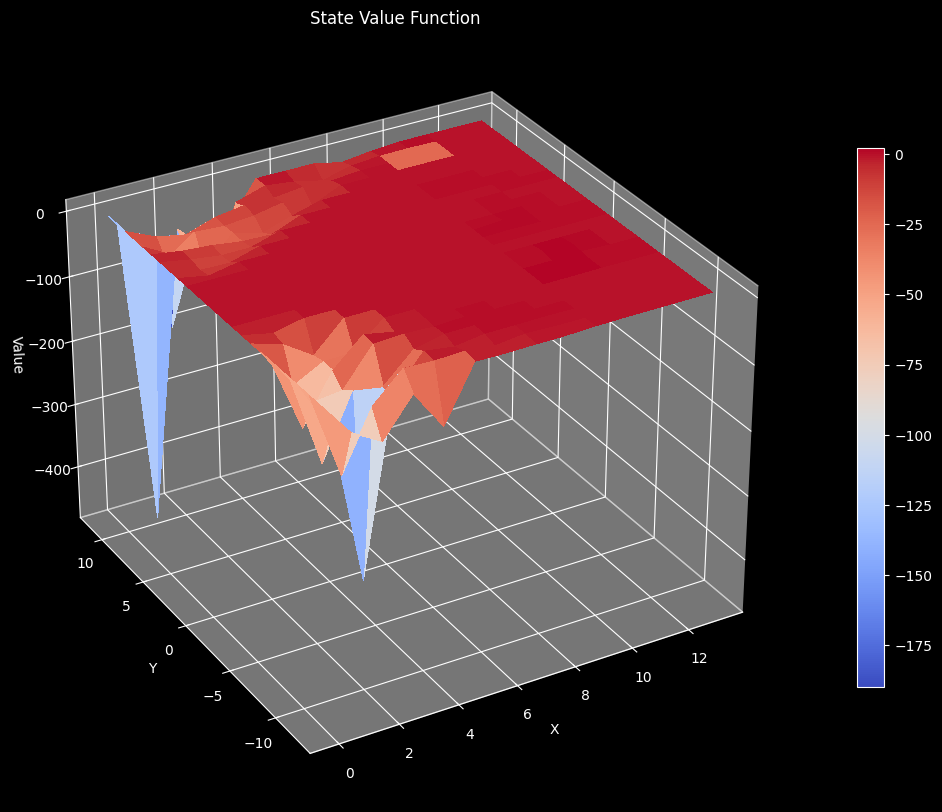

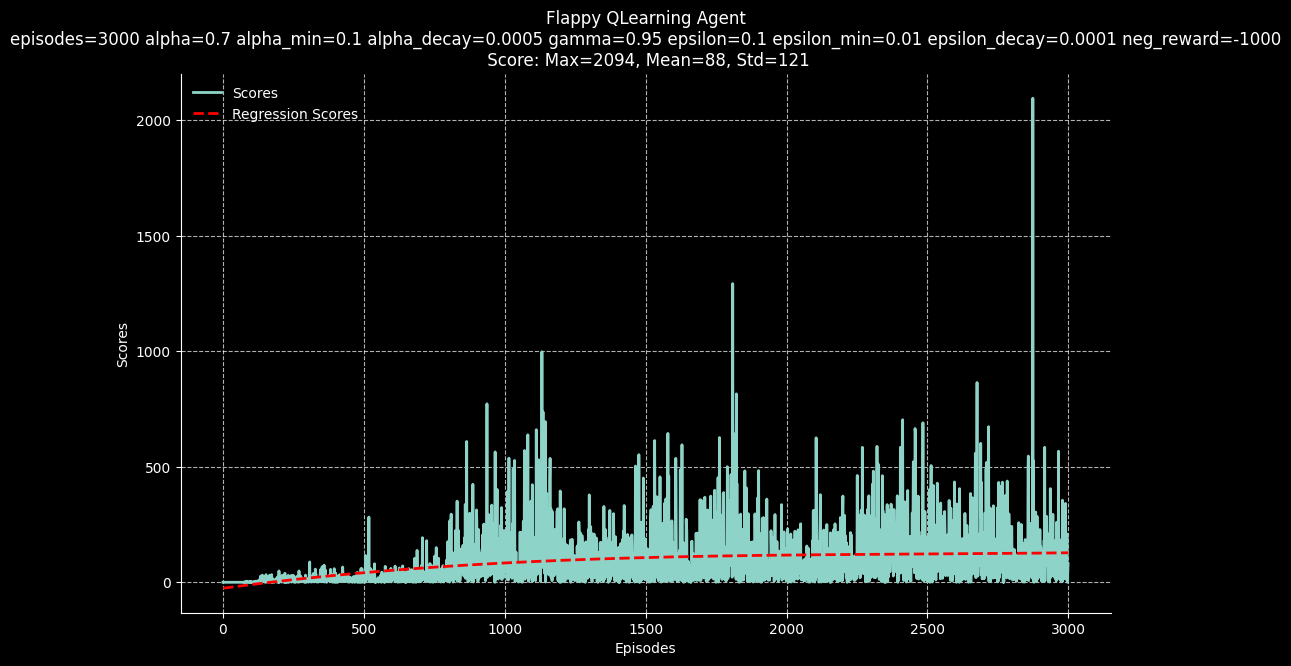

Time elapsed: 118 seconds


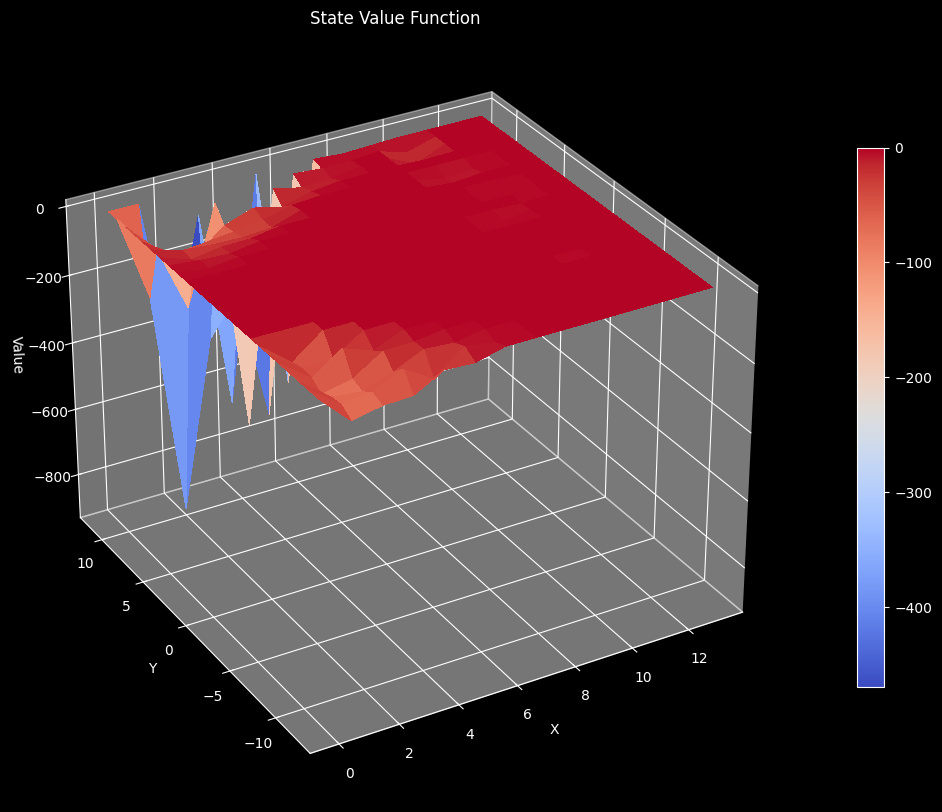

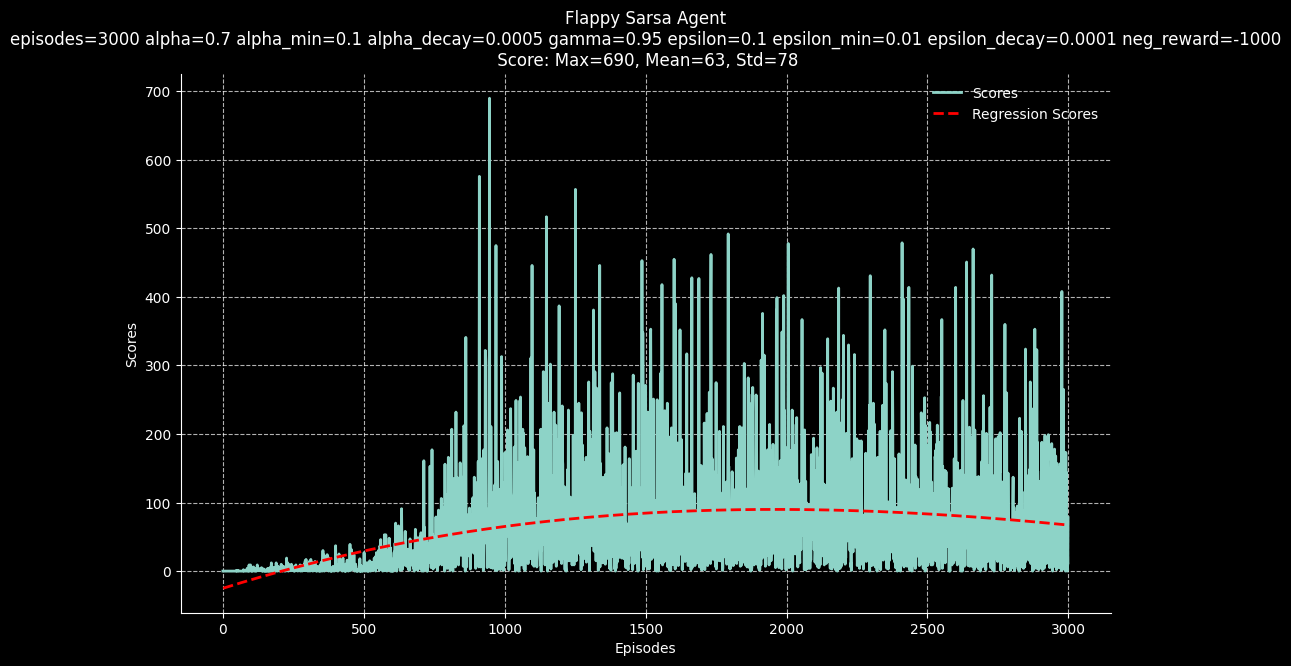

Time elapsed: 68 seconds


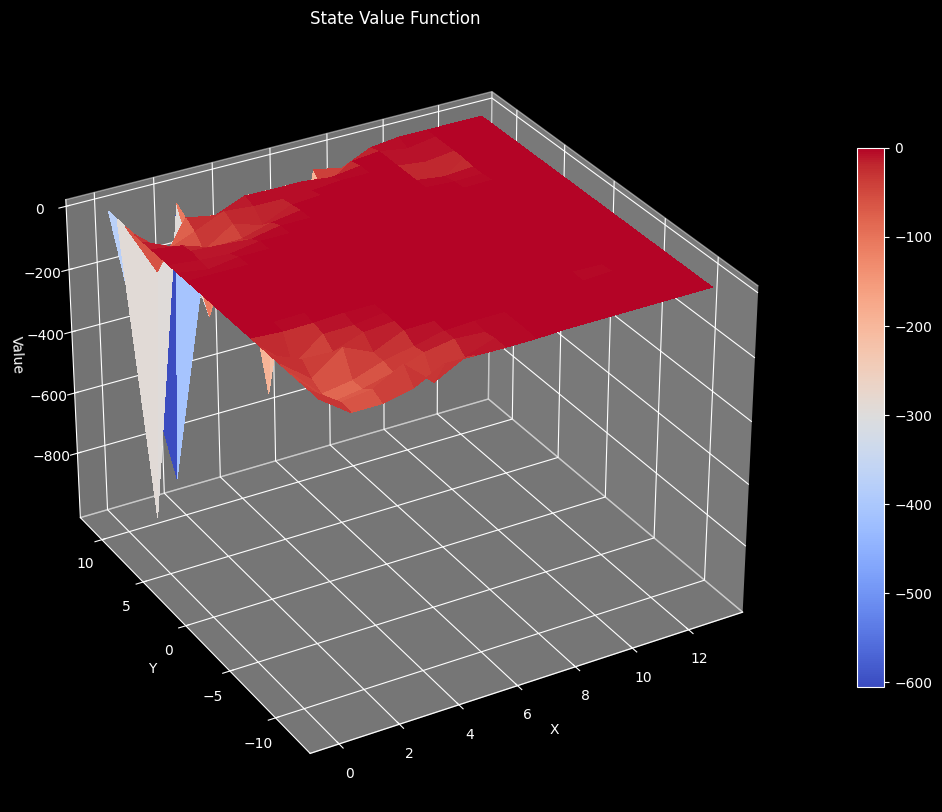

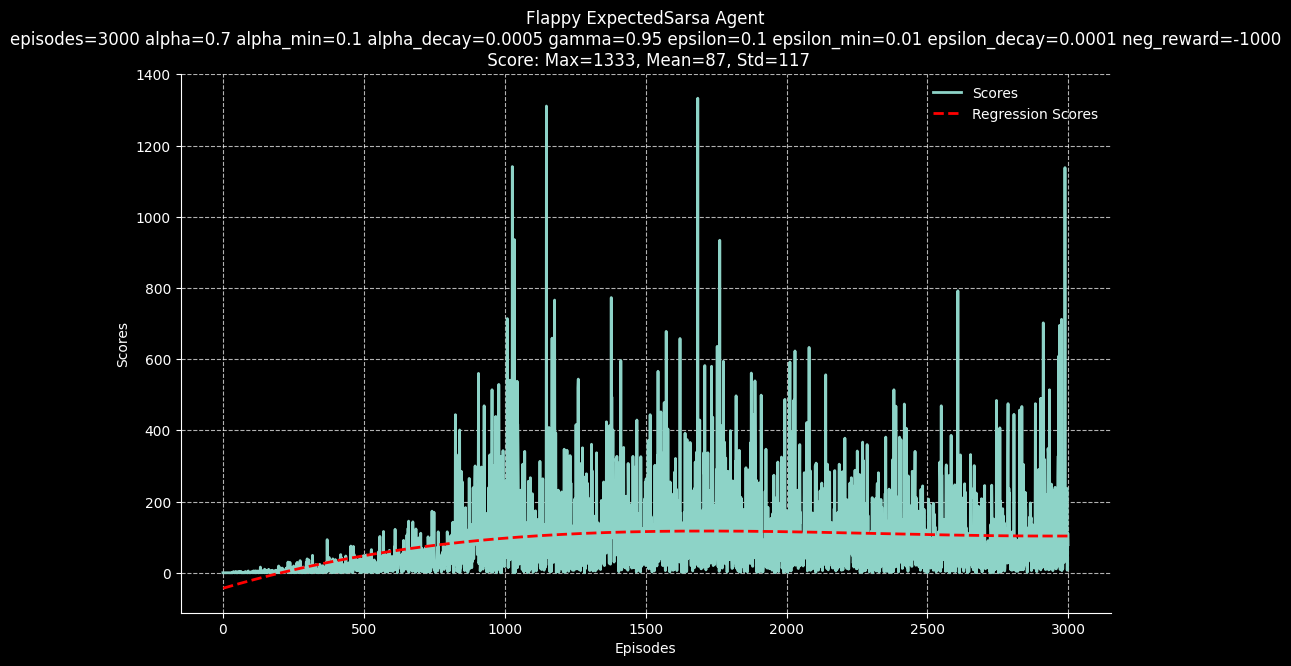

Time elapsed: 139 seconds


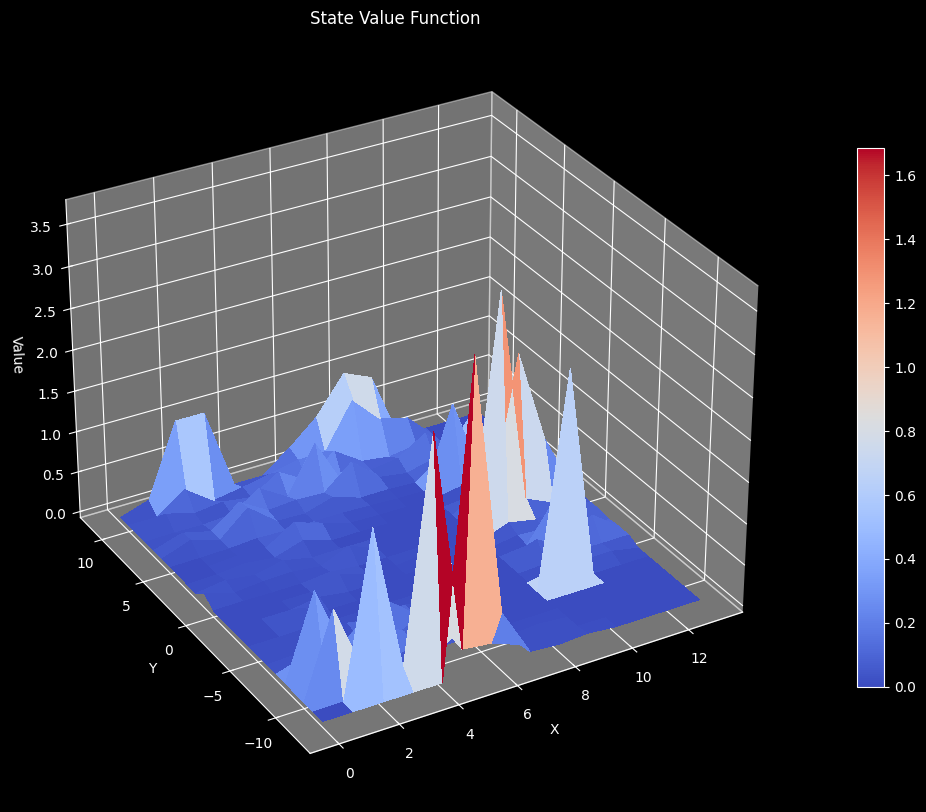

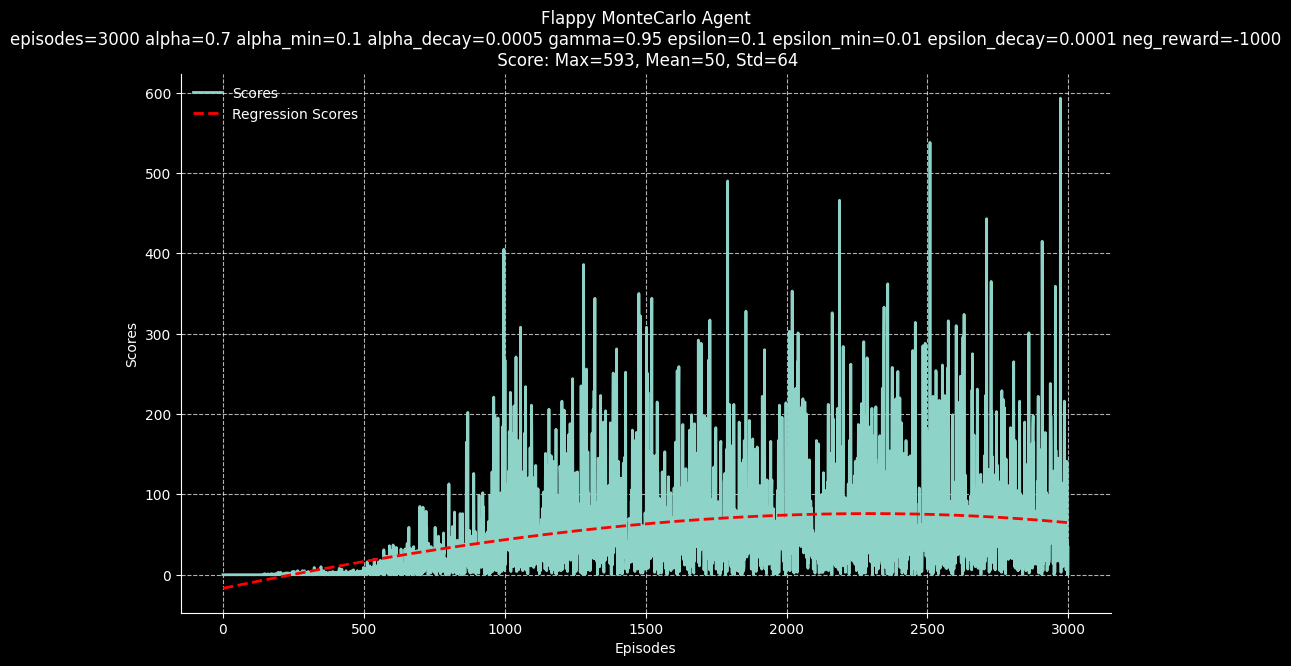

Time elapsed: 42 seconds


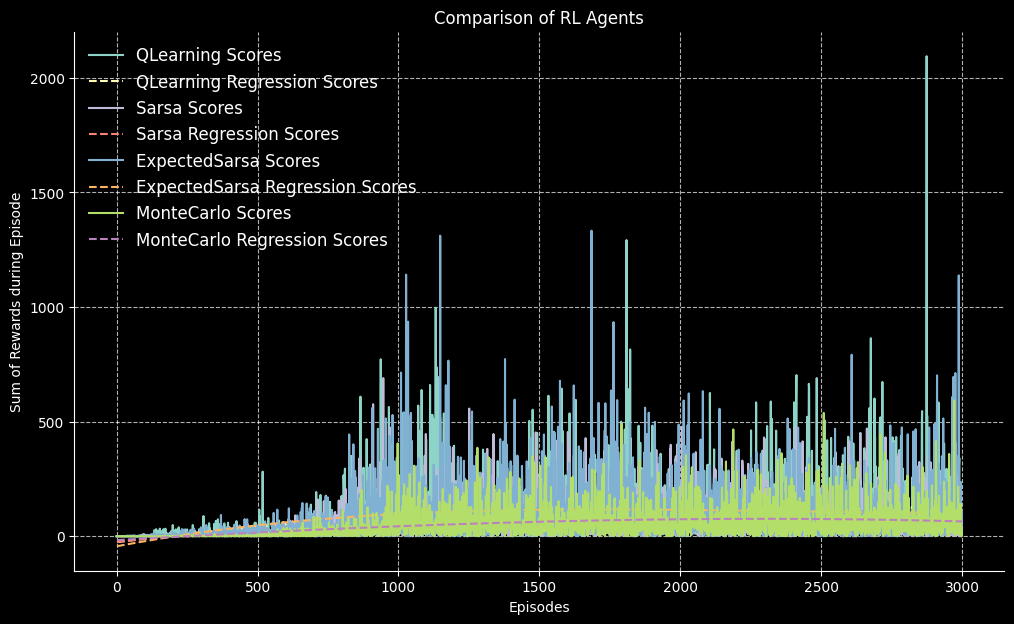

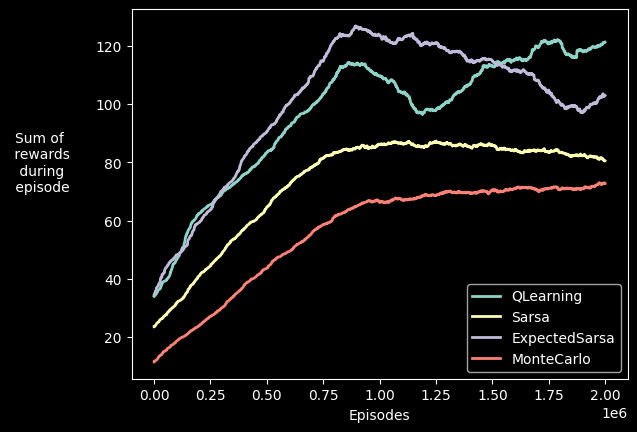

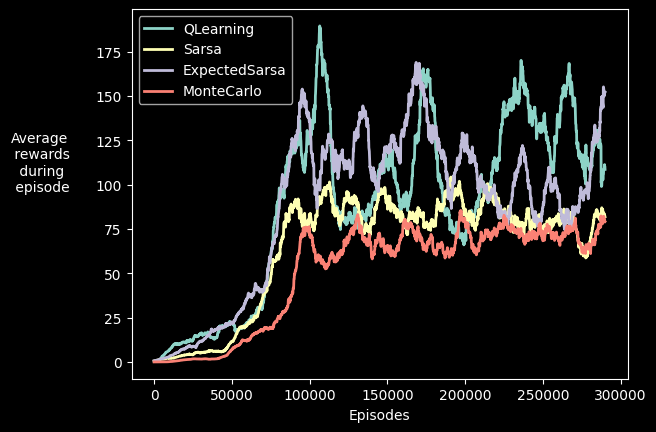

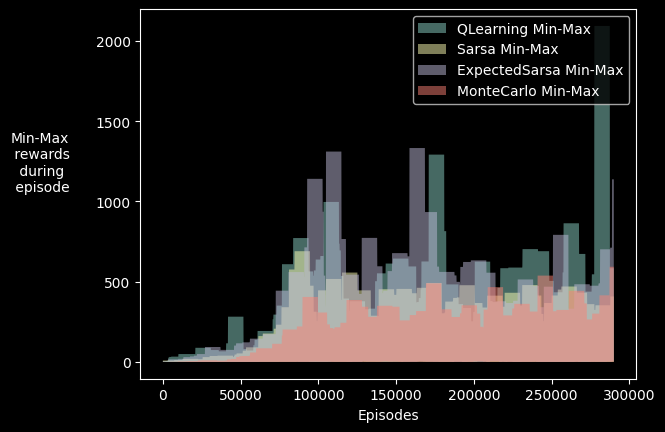

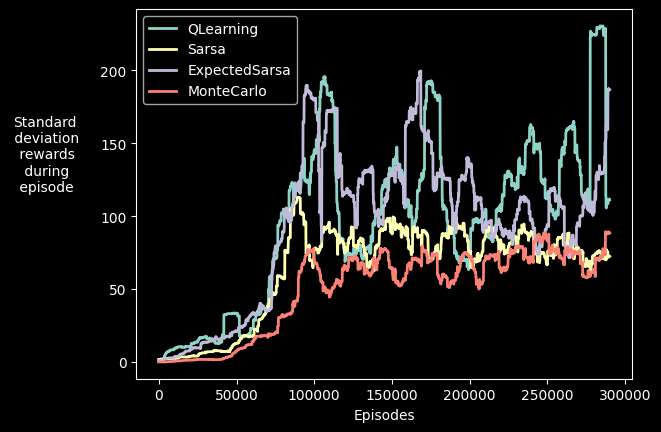

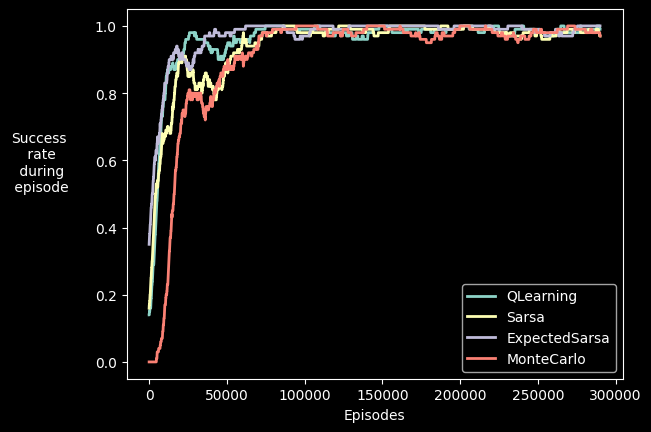

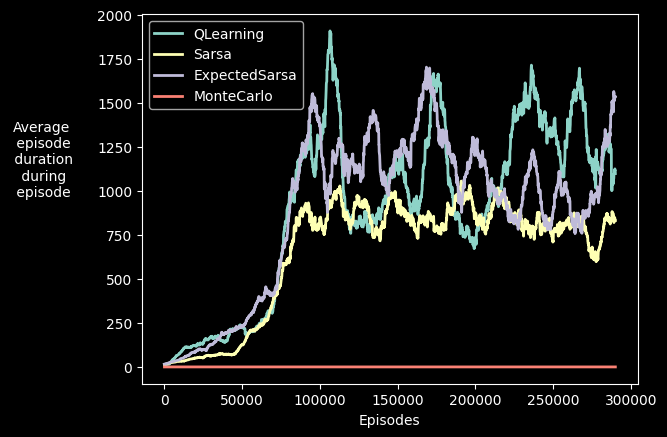

           Agent  Episodes   Alpha  Alpha Decay  Gamma  Epsilon  \
0      QLearning      3000  0.0995       0.0005   0.95     0.01   
1          Sarsa      3000  0.0995       0.0005   0.95     0.01   
2  ExpectedSarsa      3000  0.0995       0.0005   0.95     0.01   
3     MonteCarlo      3000  0.0995       0.0005   0.95     0.01   

   Epsilon Decay  Neg Reward  Max Score  
0         0.0001       -1000       2094  
1         0.0001       -1000        690  
2         0.0001       -1000       1333  
3         0.0001       -1000        593  
Maximum score achieved by QLearning agent: 2094
Maximum score achieved by Sarsa agent: 690
Maximum score achieved by ExpectedSarsa agent: 1333
Maximum score achieved by MonteCarlo agent: 593


In [20]:
# The main function is the entry point of the program, responsible for orchestrating 
# the training and evaluation of multiple Flappy Bird agents. 
def main():
    plt.style.use('dark_background')
    mpl.rcParams['font.family'] = 'sans-serif'
    np.random.seed(42)

    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    lesagentsss = ['QLearning', 'Sarsa', 'ExpectedSarsa', 'MonteCarlo']

    summaries = []
    agent_scores = {}
    agent_durations = {}
    for lesagents in lesagentsss:
        agent = Agent(env, lesagents=lesagents, plot=True)
        agent.learn()
        summary_df = agent.summary()
        summaries.append(summary_df)
        agent_scores[lesagents] = agent.state['scores']
        agent_durations[lesagents] = agent.state['durations']

    compare_agent_scores(agent_scores)
    plot_moving_average_rewards(agent_scores)
    plot_average_rewards(agent_scores)
    plot_min_max_rewards(agent_scores)
    plot_standard_deviation_rewards(agent_scores)
    plot_success_rate(agent_scores)
    plot_average_episode_duration(agent_durations)

    combined_summary = pd.concat(summaries, axis=0, ignore_index=True)
    print(combined_summary)

    for summary_df in summaries:
        print(f"Maximum score achieved by {summary_df['Agent'].iloc[0]} agent: {summary_df['Max Score'].iloc[0]}")

if __name__ == "__main__":
    main()
